In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style(style = 'ticks')
import warnings
import scipy.stats as stats
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
#df = pd.read_csv(os.path.join('2024-07-20_3_29pm.csv'))
df = pd.read_csv(os.path.join('data_set_final.csv'))

In [3]:
# Converter a coluna DATA_VENDA para o formato de data
df['DATA_VENDA'] = pd.to_datetime(df['DATA_VENDA'])


In [4]:
df["ABERTURA_LOJA"] = pd.to_datetime(df["ABERTURA_LOJA"],format="%H:%M")
df["FECHO_LOJA"] = pd.to_datetime(df["FECHO_LOJA"],format="%H:%M")

In [5]:
df["TEMPO_ABERTURA"] = df["FECHO_LOJA"]-df["ABERTURA_LOJA"]
df["HORAS_ABERTURA"] = df["TEMPO_ABERTURA"].dt.total_seconds() / 3600

In [6]:
df[df['PRODUTIVIDADE_HORA'] == 0]['LOJA'].unique()

array(['S - Vila Franca de Xira', 'S - Cacilhas', 'S - Ajuda'],
      dtype=object)

In [7]:
df[df['LOJA'] == 'S - Vila Franca de Xira']['TOTAL_COLABORADORES'].unique()

array([11], dtype=int64)

In [8]:
df[df['LOJA'] == 'S - Cacilhas']['TOTAL_COLABORADORES'].unique()

array([13], dtype=int64)

In [9]:
df[df['LOJA'] == 'S - Ajuda']['TOTAL_COLABORADORES'].unique()

array([16], dtype=int64)

In [10]:
df[df['LOJA'] == 'S - Vila Franca de Xira']['ITEMS'].sum()

2891576

In [11]:
df[df['LOJA'] ==  'S - Cacilhas']['ITEMS'].sum()

5067292

In [12]:
df[df['LOJA'] ==  'S - Ajuda']['ITEMS'].sum()

4050829

In [13]:
##158 PARA S - Ajuda
##147 para S - Cacilhas
##149 S - Vila Franca de Xira 

In [14]:
df.loc[(df['PRODUTIVIDADE_HORA'] == 0) & (df['LOJA'] == 'S - Vila Franca de Xira'), 'PRODUTIVIDADE_HORA'] = 149
df.loc[(df['PRODUTIVIDADE_HORA'] == 0) & (df['LOJA'] == 'S - Cacilhas'), 'PRODUTIVIDADE_HORA'] = 147
df.loc[(df['PRODUTIVIDADE_HORA'] == 0) & (df['LOJA'] == 'S - Ajuda'), 'PRODUTIVIDADE_HORA'] = 158


In [15]:
df[df['PRODUTIVIDADE_HORA'] == 0]['LOJA'].unique()

array([], dtype=object)

In [16]:
df[df['LOJA'] == 'S - Vila Franca de Xira']['PRODUTIVIDADE_HORA'].unique()

array([149], dtype=int64)

In [17]:
df[df['LOJA'] == 'S - Cacilhas']['PRODUTIVIDADE_HORA'].unique()

array([147], dtype=int64)

In [18]:
df[df['LOJA'] == 'S - Ajuda']['PRODUTIVIDADE_HORA'].unique()

array([158], dtype=int64)

In [19]:
# Identify the first sales date for each store
first_sales_date = df.groupby('LOJA')['DATA_VENDA'].min().reset_index()

# Create a complete date range for each store starting from the first sales date
complete_data = pd.DataFrame()

for _, row in first_sales_date.iterrows():
    store = row['LOJA']
    start_date = row['DATA_VENDA']
    end_date = df['DATA_VENDA'].max()
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    store_data = pd.DataFrame({'LOJA': store, 'DATA_VENDA': all_dates})
    complete_data = pd.concat([complete_data, store_data])

# Merge the complete date range with the original data
data_set_final_complete = pd.merge(complete_data, df, on=['LOJA', 'DATA_VENDA'], how='left')

# Define the holiday dates and their respective names
holiday_names = {
    '2020-12-25': 'Dia de Natal',
    '2021-12-25': 'Dia de Natal',
    '2022-12-25': 'Dia de Natal',
    '2019-01-01': 'Dia Ano Novo',
    '2020-01-01': 'Dia Ano Novo',
    '2021-01-01': 'Dia Ano Novo',
    '2022-01-01': 'Dia Ano Novo',
    '2013-01-01': 'Dia Ano Novo'
}
holiday_dates = pd.to_datetime(list(holiday_names.keys()))

# Create a mask for holiday dates
holiday_mask = data_set_final_complete['DATA_VENDA'].isin(holiday_dates)

# Set the holiday and store_open columns for the specific holiday dates
data_set_final_complete.loc[holiday_mask, 'FERIADO_FIXO'] = 1
data_set_final_complete.loc[holiday_mask, 'ABERTURA_FERIADO'] = 0

# Set VALOR_VENDA and ITEMS to 0 for holidays where the store is closed
data_set_final_complete.loc[holiday_mask, ['VALOR_VENDA', 'ITEMS']] = 0

# Fill DATA_FERIADO with DATA_VENDA for holidays
data_set_final_complete.loc[holiday_mask, 'DATA_FERIADO'] = data_set_final_complete.loc[holiday_mask, 'DATA_VENDA']

# Fill TIPO_FERIADO with specific names for holidays
for date, name in holiday_names.items():
    mask_date = (data_set_final_complete['DATA_VENDA'] == pd.to_datetime(date))
    data_set_final_complete.loc[mask_date, 'TIPO_FERIADO'] = name

# Fill missing sales using the average of the last 4 values for the same day of the week
data_set_final_complete['day_of_week'] = data_set_final_complete['DATA_VENDA'].dt.dayofweek

def fill_with_rolling_avg(group):
    group = group.sort_values('DATA_VENDA')
    group['rolling_avg_sales'] = group['VALOR_VENDA'].rolling(window=4, min_periods=1).mean()
    group['VALOR_VENDA'] = group['VALOR_VENDA'].fillna(group['rolling_avg_sales'])
    group['rolling_avg_items'] = group['ITEMS'].rolling(window=4, min_periods=1).mean()
    group['ITEMS'] = group['ITEMS'].fillna(group['rolling_avg_items'])
    group['rolling_avg_SKUS_UP'] = group['SKUS_UP'].rolling(window=4, min_periods=1).mean()
    group['SKUS_UP'] = group['SKUS_UP'].fillna(group['rolling_avg_SKUS_UP'])
    group['rolling_avg_SKUS_DOWN'] = group['SKUS_DOWN'].rolling(window=4, min_periods=1).mean()
    group['SKUS_DOWN'] = group['SKUS_DOWN'].fillna(group['rolling_avg_SKUS_DOWN'])
    group['rolling_avg_AUMENTO_PRECO'] = group['AUMENTO_PRECO'].rolling(window=4, min_periods=1).mean()
    group['AUMENTO_PRECO'] = group['AUMENTO_PRECO'].fillna(group['rolling_avg_AUMENTO_PRECO'])
    group['rolling_avg_DESCIDA_PRECO'] = group['DESCIDA_PRECO'].rolling(window=4, min_periods=1).mean()
    group['DESCIDA_PRECO'] = group['DESCIDA_PRECO'].fillna(group['rolling_avg_DESCIDA_PRECO'])
    return group

# Apply the function to each store and day of the week
filled_data = data_set_final_complete.groupby(['LOJA', 'day_of_week']).apply(fill_with_rolling_avg)

# Reset index to avoid ambiguity
filled_data.reset_index(drop=True, inplace=True)

# Apply forward and backward fill to any remaining missing values for sales and items
filled_data['VALOR_VENDA'] = filled_data['VALOR_VENDA'].fillna(method='ffill').fillna(method='bfill')
filled_data['ITEMS'] = filled_data['ITEMS'].fillna(method='ffill').fillna(method='bfill')
filled_data['SKUS_UP'] = filled_data['ITEMS'].fillna(method='ffill').fillna(method='bfill')
filled_data['SKUS_DOWN'] = filled_data['ITEMS'].fillna(method='ffill').fillna(method='bfill')
filled_data['AUMENTO_PRECO'] = filled_data['ITEMS'].fillna(method='ffill').fillna(method='bfill')
filled_data['DESCIDA_PRECO'] = filled_data['ITEMS'].fillna(method='ffill').fillna(method='bfill')

# Sort the DataFrame by LOJA and DATA_VENDA
filled_data = filled_data.sort_values(by=['LOJA', 'DATA_VENDA'])

# Forward-fill and backward-fill the missing values for the other columns
columns_to_fill = ['LOJA_ID', 'CIDADE', 'REGIAO', 'ABERTURA_LOJA', 'FECHO_LOJA', "HORAS_ABERTURA","TEMPO_ABERTURA", "TOTAL_COLABORADORES","SKUS","CAIXAS_TRADICIONAIS","SELF_CHECKOUT", "PRODUTIVIDADE_HORA"
]
filled_data[columns_to_fill] = filled_data.groupby('LOJA')[columns_to_fill].fillna(method='ffill').fillna(method='bfill')
# Drop the helper columns if no longer needed
# filled_data.drop(columns=['day_of_week', 'rolling_avg'], inplace=True)

In [20]:
filled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100507 entries, 598 to 98995
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype          
---  ------                     --------------   -----          
 0   LOJA                       100507 non-null  object         
 1   DATA_VENDA                 100507 non-null  datetime64[ns] 
 2   LOJA_ID                    100507 non-null  object         
 3   CIDADE                     100507 non-null  object         
 4   REGIAO                     100507 non-null  object         
 5   PRODUTIVIDADE_HORA         100507 non-null  float64        
 6   TOTAL_COLABORADORES        100507 non-null  float64        
 7   SKUS                       100507 non-null  float64        
 8   CAIXAS_TRADICIONAIS        100507 non-null  float64        
 9   SELF_CHECKOUT              100507 non-null  float64        
 10  ABERTURA_LOJA              100507 non-null  datetime64[ns] 
 11  FECHO_LOJA                 100507 non-null 

In [21]:
filled_data['VALOR_VENDA'].sum()

4495341333.191668

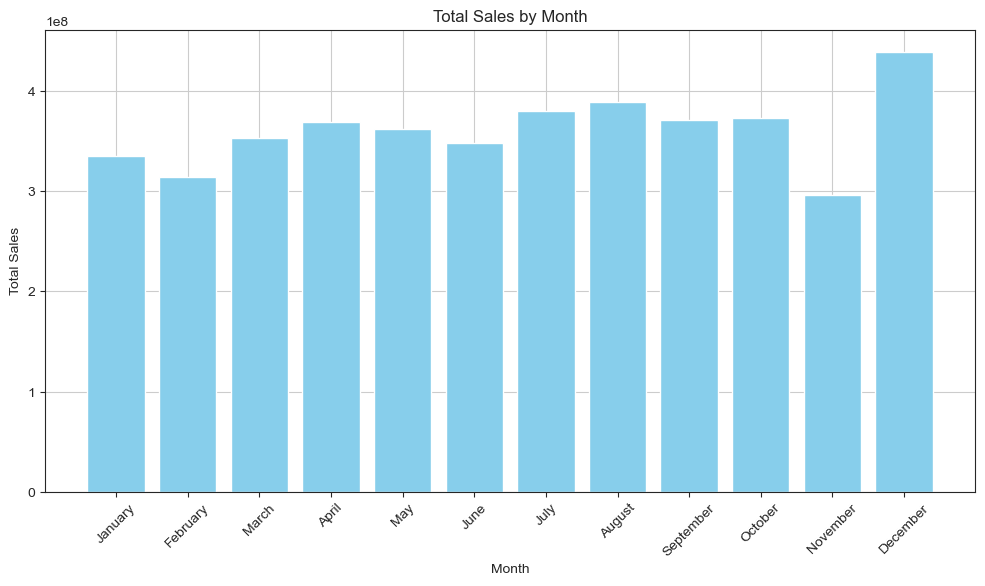

In [22]:
###Vendas Mês
# Filter out partial months
start_date = '2019-10-30'
end_date = '2023-10-30'
filtered_data = filled_data[(filled_data['DATA_VENDA'] >= start_date) & (filled_data['DATA_VENDA'] <= end_date)]

# Extract the month name
filtered_data['month_name'] = filtered_data['DATA_VENDA'].dt.strftime('%B')

# Aggregate sales by month name
sales_by_month_name = filtered_data.groupby('month_name')['VALOR_VENDA'].sum().reindex(
    ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
).reset_index()

# Plot the aggregated sales data
plt.figure(figsize=(12, 6))
plt.bar(sales_by_month_name['month_name'], sales_by_month_name['VALOR_VENDA'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [23]:
filtered_data['MES'] = filtered_data['DATA_VENDA'].dt.month

In [24]:
# Aggregate data by store, month, and region
monthly_data_by_store = filtered_data.groupby(['LOJA', 'REGIAO', 'MES', 'PRODUTIVIDADE_HORA']).agg(
    VENDA_TOTAL=('VALOR_VENDA', 'sum'),
).reset_index()

In [25]:
monthly_data_by_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LOJA                840 non-null    object 
 1   REGIAO              840 non-null    object 
 2   MES                 840 non-null    int32  
 3   PRODUTIVIDADE_HORA  840 non-null    float64
 4   VENDA_TOTAL         840 non-null    float64
dtypes: float64(2), int32(1), object(2)
memory usage: 29.7+ KB


In [26]:
monthly_data_by_store['VENDA_TOTAL'].sum()

4326177219.941667

In [27]:
# Check for NaN values
print("NaN values in relevant_data:")
print(monthly_data_by_store.isna().sum())

NaN values in relevant_data:
LOJA                  0
REGIAO                0
MES                   0
PRODUTIVIDADE_HORA    0
VENDA_TOTAL           0
dtype: int64


In [28]:
# Encode 'store' and 'region' using Label Encoding
le_store = LabelEncoder()
monthly_data_by_store['store_encoded'] = le_store.fit_transform(monthly_data_by_store['LOJA'])

le_region = LabelEncoder()
monthly_data_by_store['region_encoded'] = le_region.fit_transform(monthly_data_by_store['REGIAO'])

In [29]:
# Check for NaN values
print("NaN values in relevant_data:")
print(monthly_data_by_store.isna().sum())

NaN values in relevant_data:
LOJA                  0
REGIAO                0
MES                   0
PRODUTIVIDADE_HORA    0
VENDA_TOTAL           0
store_encoded         0
region_encoded        0
dtype: int64


In [30]:
# Prepare features for clustering
features = monthly_data_by_store[['VENDA_TOTAL', 'store_encoded', 'region_encoded', 'MES', 'PRODUTIVIDADE_HORA']]

In [31]:
# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

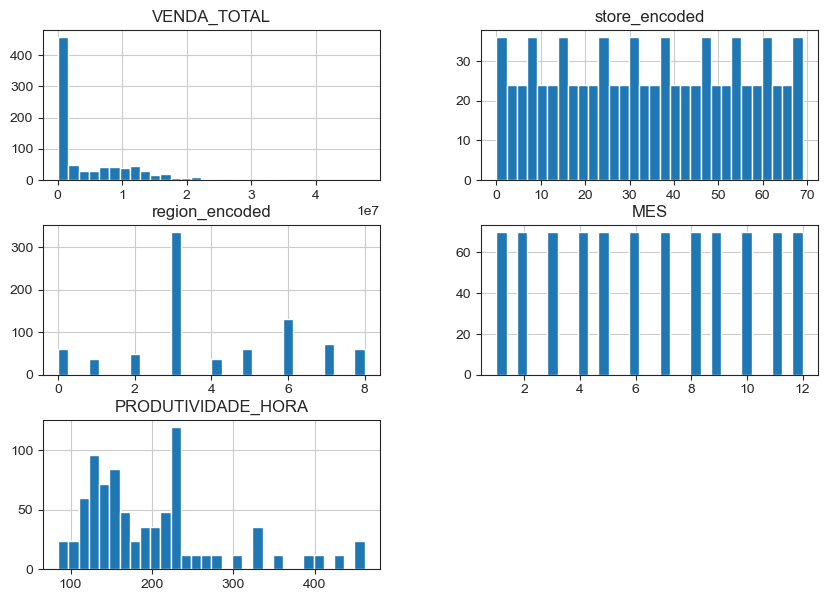

In [32]:
# Plot histograms of the features to check distributions
features[['VENDA_TOTAL', 'store_encoded', 'region_encoded', 'MES', 'PRODUTIVIDADE_HORA']].hist(bins=30, figsize=(10, 7))
plt.show()

In [33]:
# Determine the optimal number of clusters using Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

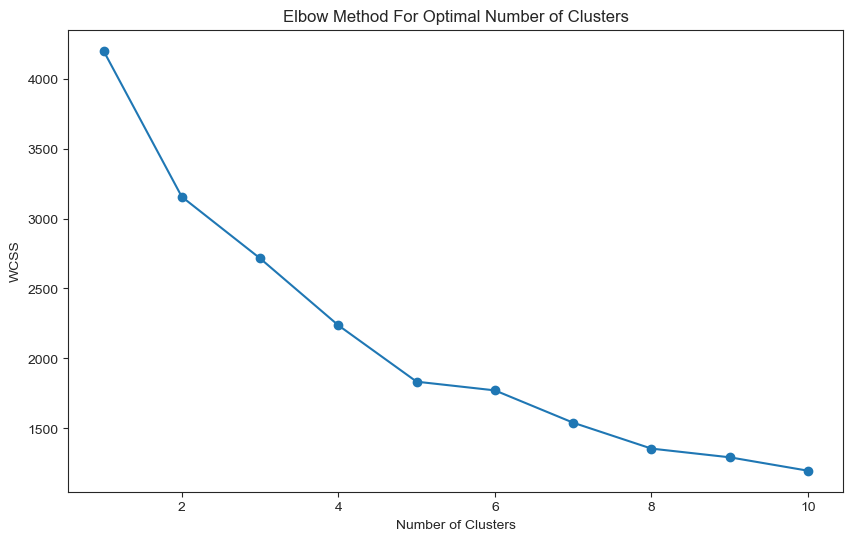

In [34]:
# Plot Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [35]:
# Apply K-Means clustering with the chosen number of clusters (e.g., 5)
optimal_clusters = 5  # Adjust based on the elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
monthly_data_by_store['cluster'] = kmeans.fit_predict(features_scaled)

In [36]:
# Run PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)
monthly_data_by_store['PCA1'] = pca_result[:, 0]
monthly_data_by_store['PCA2'] = pca_result[:, 1]

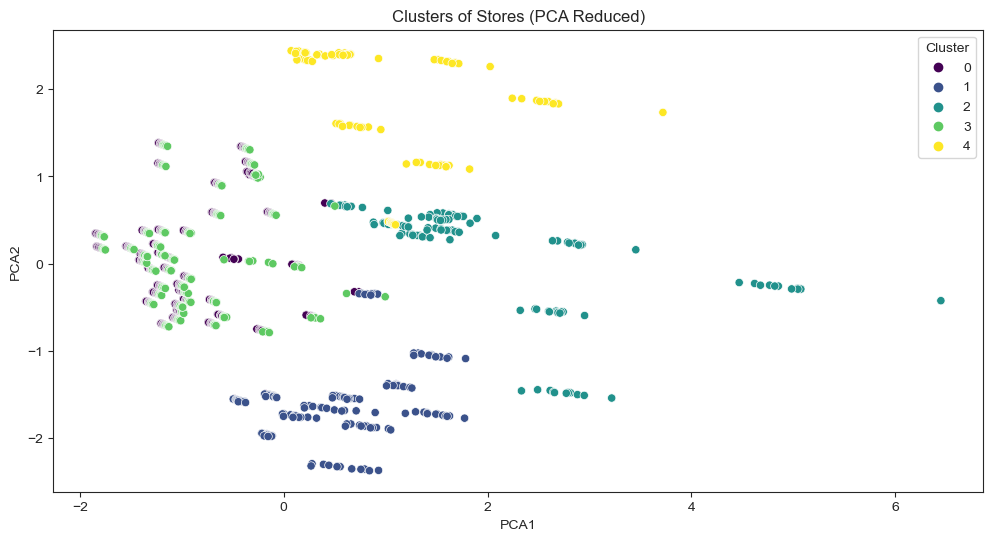

In [37]:
# Visualize clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=monthly_data_by_store, palette='viridis')
plt.title('Clusters of Stores (PCA Reduced)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

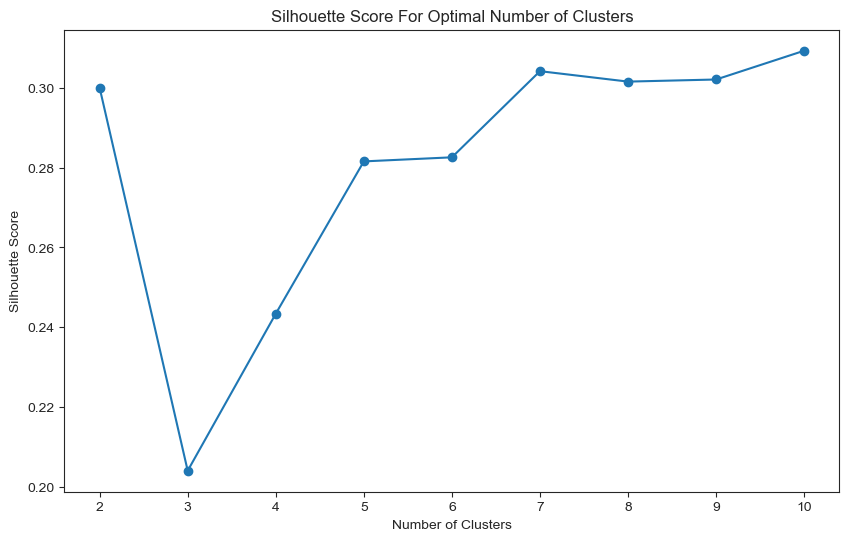

In [38]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Calculate Silhouette Score for different number of clusters
silhouette_scores = []
K = range(2, 11)  # Testing for 2 to 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(features_scaled, labels))

# Plot Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, marker='o')
plt.title('Silhouette Score For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


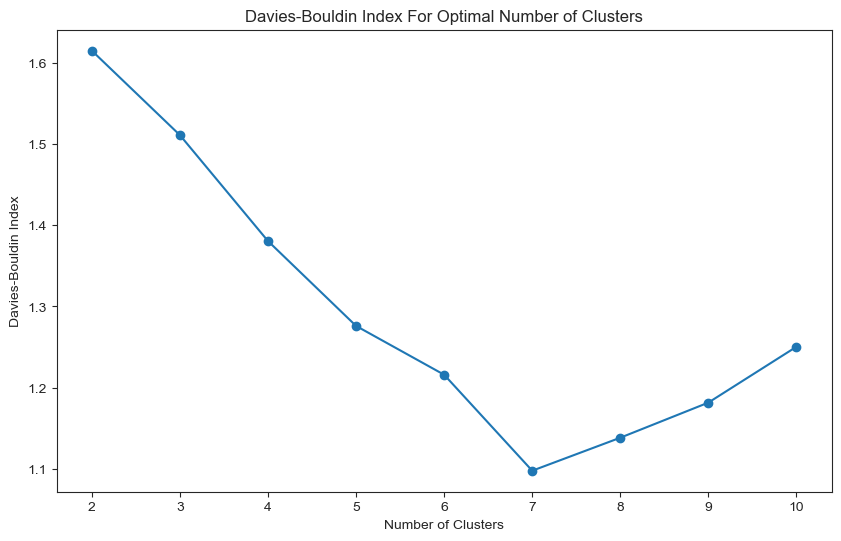

In [39]:
from sklearn.metrics import davies_bouldin_score

# Calculate Davies-Bouldin Index for different number of clusters
davies_bouldin_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    labels = kmeans.labels_
    davies_bouldin_scores.append(davies_bouldin_score(features_scaled, labels))

# Plot Davies-Bouldin Index
plt.figure(figsize=(10, 6))
plt.plot(K, davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Index For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.show()


In [40]:
# Apply K-Means clustering with the chosen number of clusters (e.g., 5)
optimal_clusters = 7  # Adjust based on the elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
monthly_data_by_store['cluster'] = kmeans.fit_predict(features_scaled)

In [41]:
# Run PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)
monthly_data_by_store['PCA1'] = pca_result[:, 0]
monthly_data_by_store['PCA2'] = pca_result[:, 1]

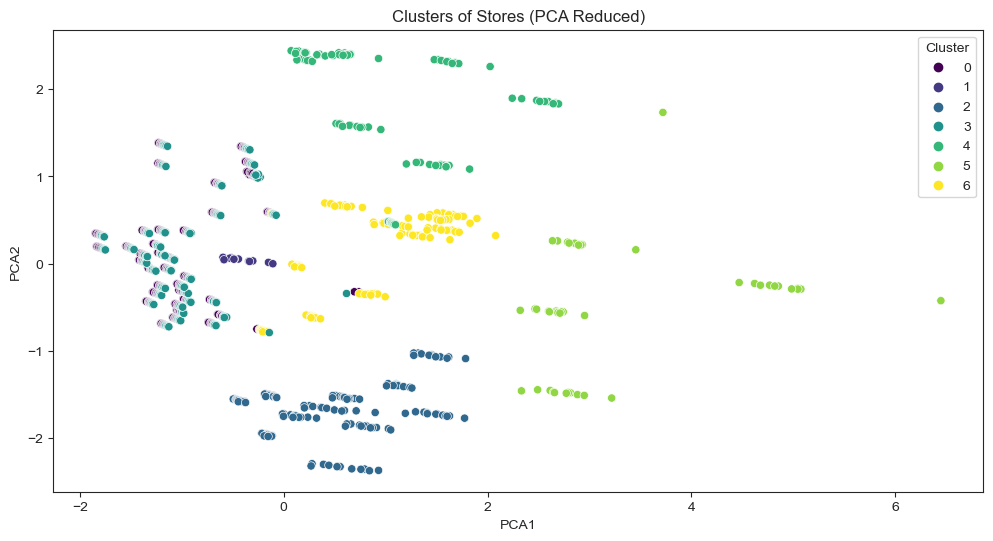

In [42]:
# Visualize clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=monthly_data_by_store, palette='viridis')
plt.title('Clusters of Stores (PCA Reduced)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

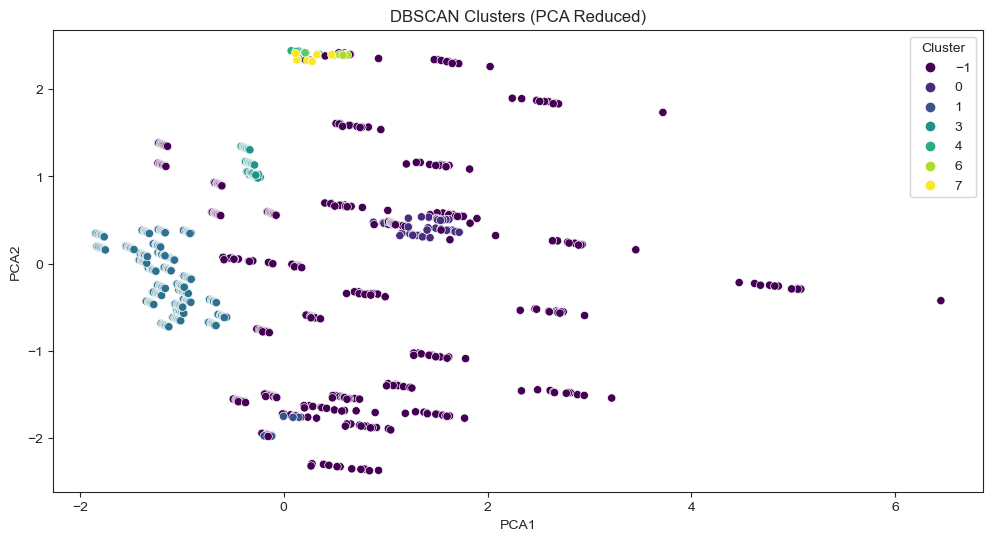

In [45]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
monthly_data_by_store['dbscan_cluster'] = dbscan.fit_predict(features_scaled)

# Plot DBSCAN clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='dbscan_cluster', data=monthly_data_by_store, palette='viridis')
plt.title('DBSCAN Clusters (PCA Reduced)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

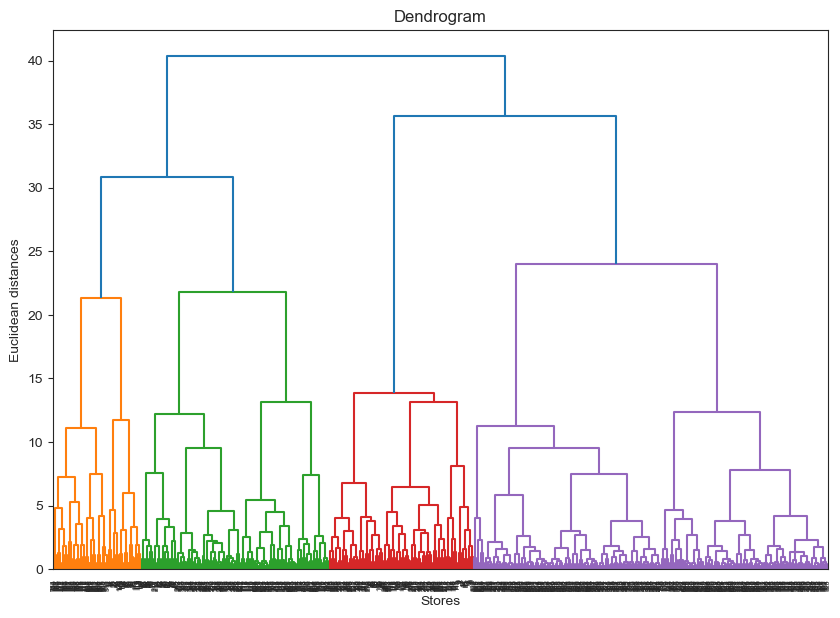

In [51]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(features_scaled, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Stores')
plt.ylabel('Euclidean distances')
plt.show()


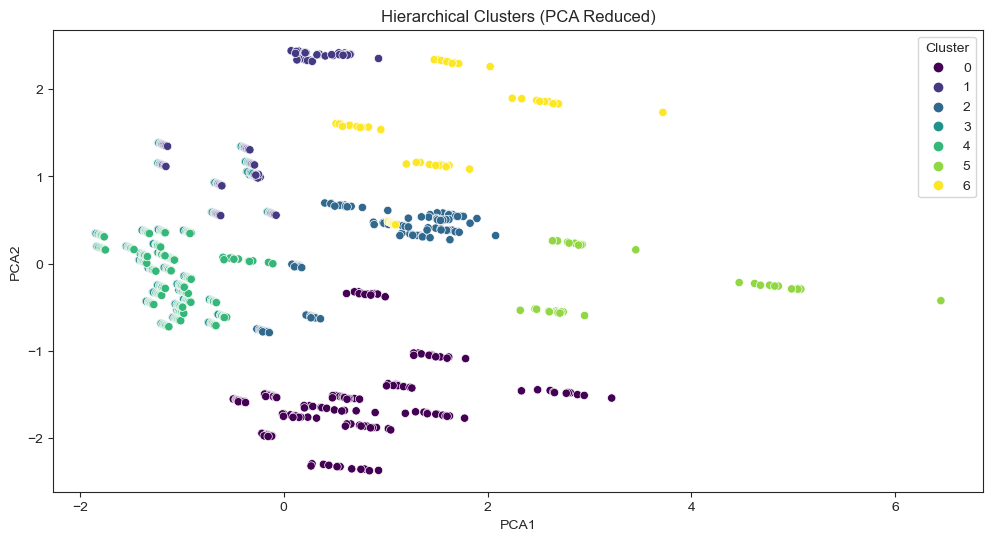

In [52]:
# Apply hierarchical clustering with updated syntax
from sklearn.cluster import AgglomerativeClustering

hierarchical_cluster = AgglomerativeClustering(n_clusters=7, linkage='ward', metric='euclidean')
monthly_data_by_store['hierarchical_cluster'] = hierarchical_cluster.fit_predict(features_scaled)

# Perform PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)
monthly_data_by_store['PCA1'] = pca_result[:, 0]
monthly_data_by_store['PCA2'] = pca_result[:, 1]

# Plot hierarchical clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='hierarchical_cluster', data=monthly_data_by_store, palette='viridis')
plt.title('Hierarchical Clusters (PCA Reduced)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

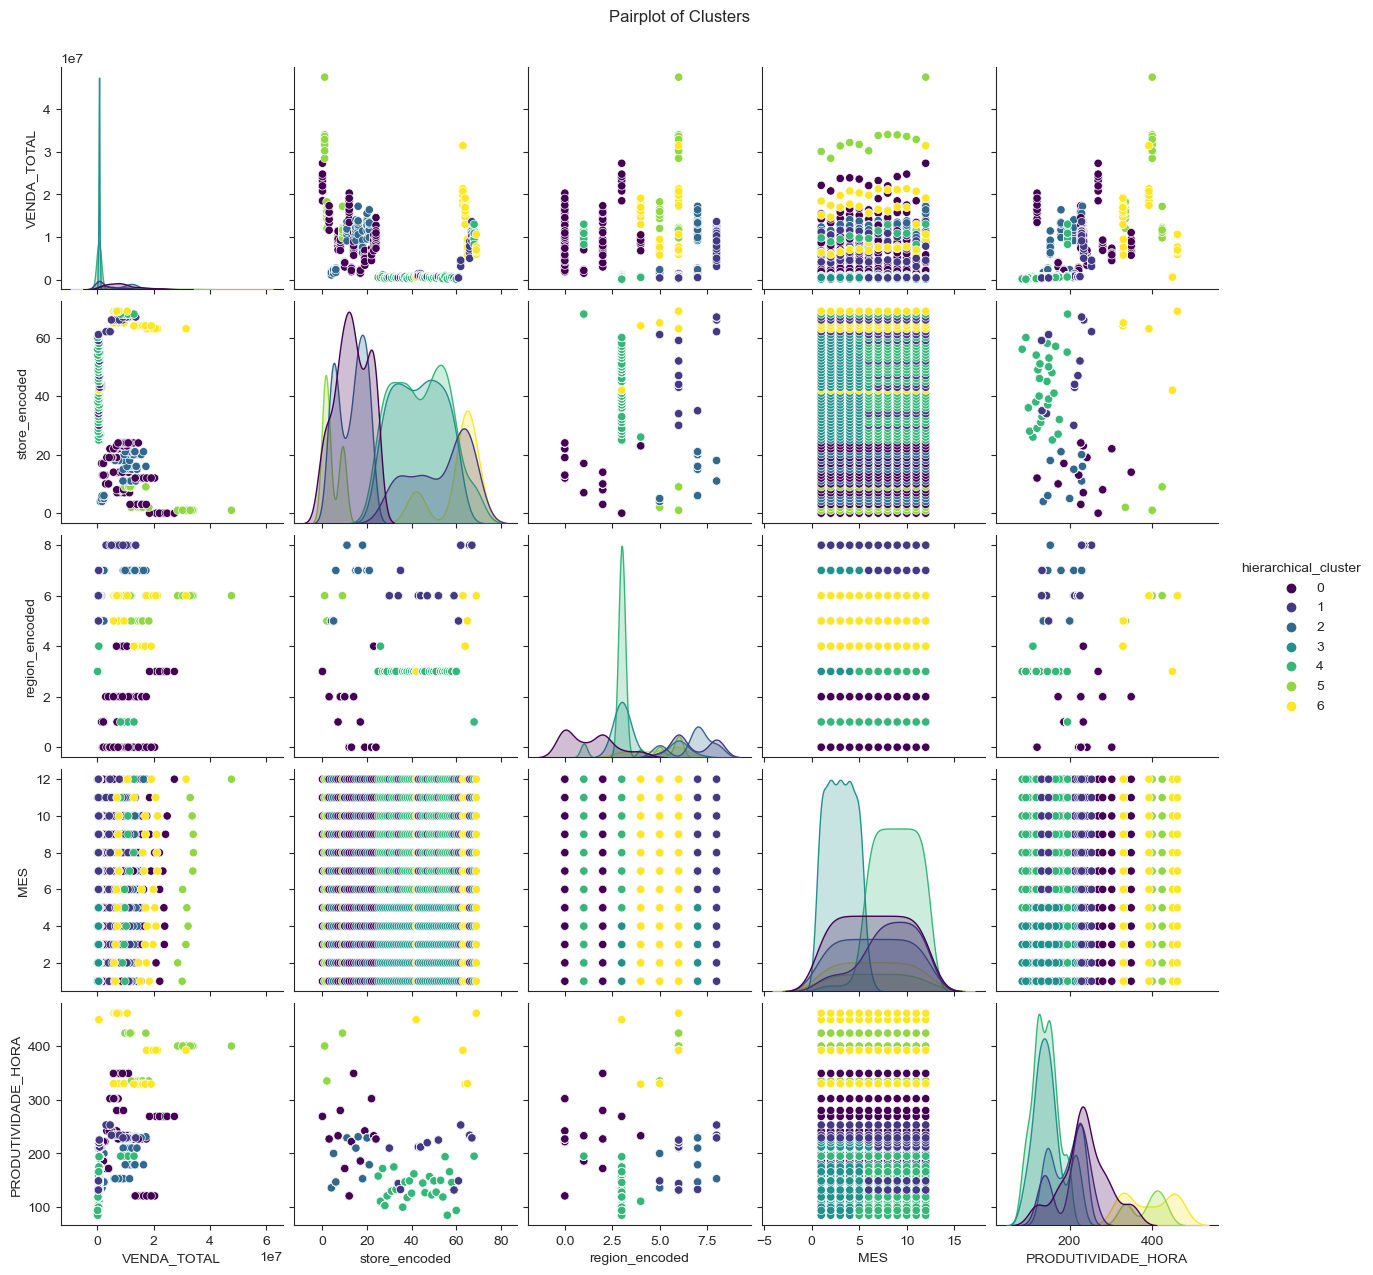

In [57]:

# Plot clusters using pairplot
sns.pairplot(monthly_data_by_store, hue='hierarchical_cluster', palette='viridis', 
             vars=(features))
plt.suptitle('Pairplot of Clusters', y=1.02)
plt.show()


#### Analisar cada cluster

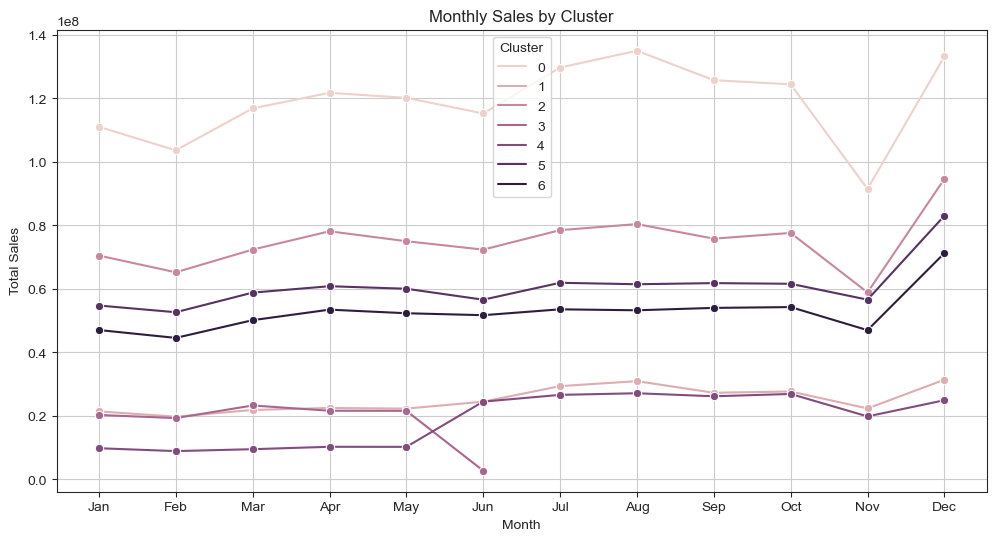

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `monthly_data` has the cluster labels and is already preprocessed

# Aggregate data by month and cluster to get total sales
clustered_monthly_sales = monthly_data_by_store.groupby(['MES', 'hierarchical_cluster']).agg(
    total_sales=('VENDA_TOTAL', 'sum')
).reset_index()

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=clustered_monthly_sales, x='MES', y='total_sales', hue='hierarchical_cluster', marker='o')

# Add titles and labels
plt.title('Monthly Sales by Cluster')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Cluster')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()


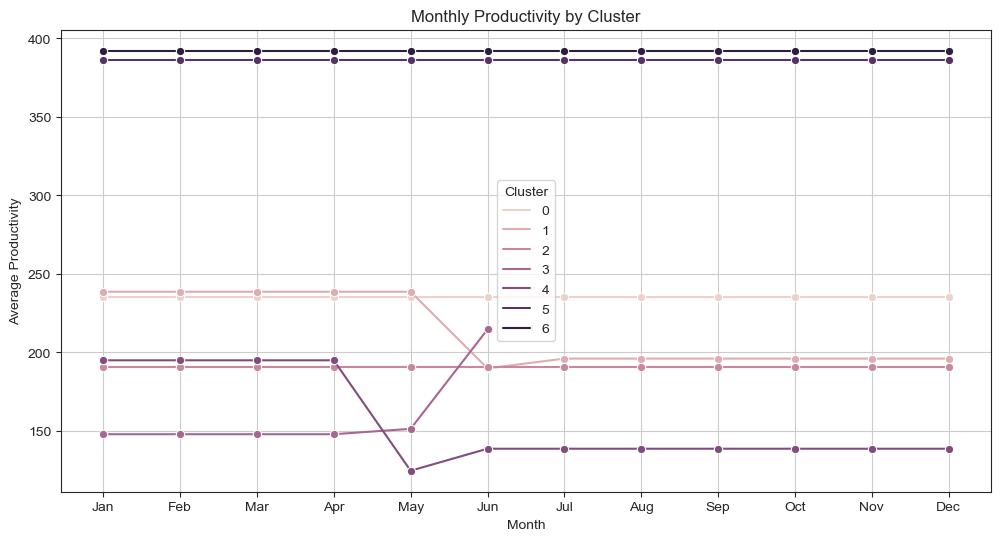

In [64]:
# Aggregate data by month and cluster to get average productivity
clustered_monthly_productivity = monthly_data_by_store.groupby(['MES', 'hierarchical_cluster']).agg(
    average_productivity=('PRODUTIVIDADE_HORA', 'mean')
).reset_index()

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=clustered_monthly_productivity, x='MES', y='average_productivity', hue='hierarchical_cluster', marker='o')

# Add titles and labels
plt.title('Monthly Productivity by Cluster')
plt.xlabel('Month')
plt.ylabel('Average Productivity')
plt.legend(title='Cluster')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


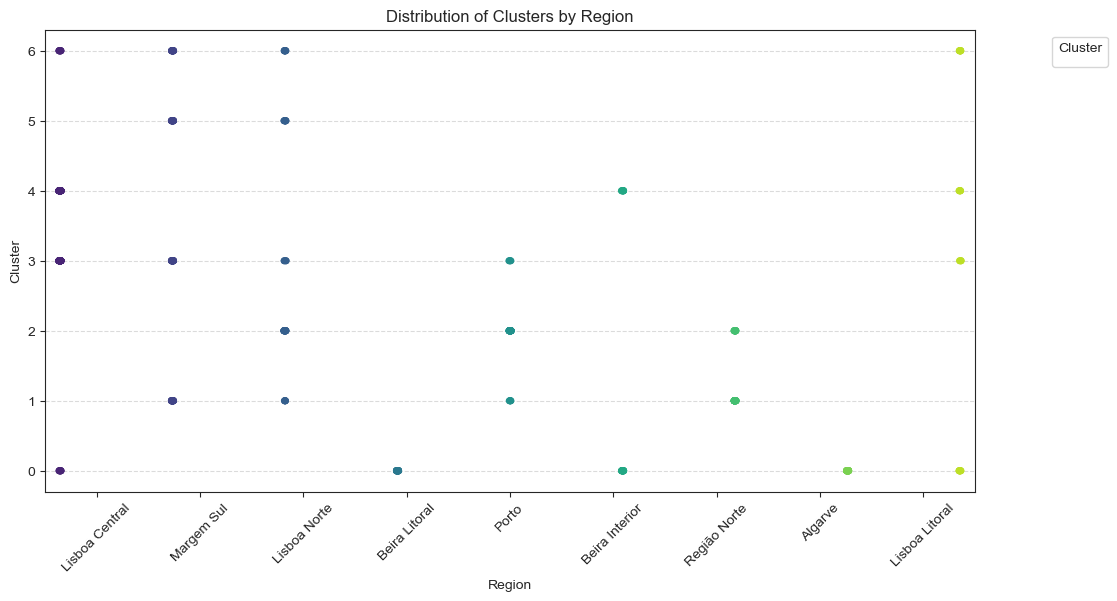

In [68]:


# Plot the distribution of clusters by region using stripplot
plt.figure(figsize=(12, 6))
sns.stripplot(data=monthly_data_by_store, x='REGIAO', y='hierarchical_cluster', jitter=True, palette='viridis', dodge=True)

# Add titles and labels
plt.title('Distribution of Clusters by Region')
plt.xlabel('Region')
plt.ylabel('Cluster')
plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.xticks(rotation=45)  # Rotate x-axis labels if region names are long
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


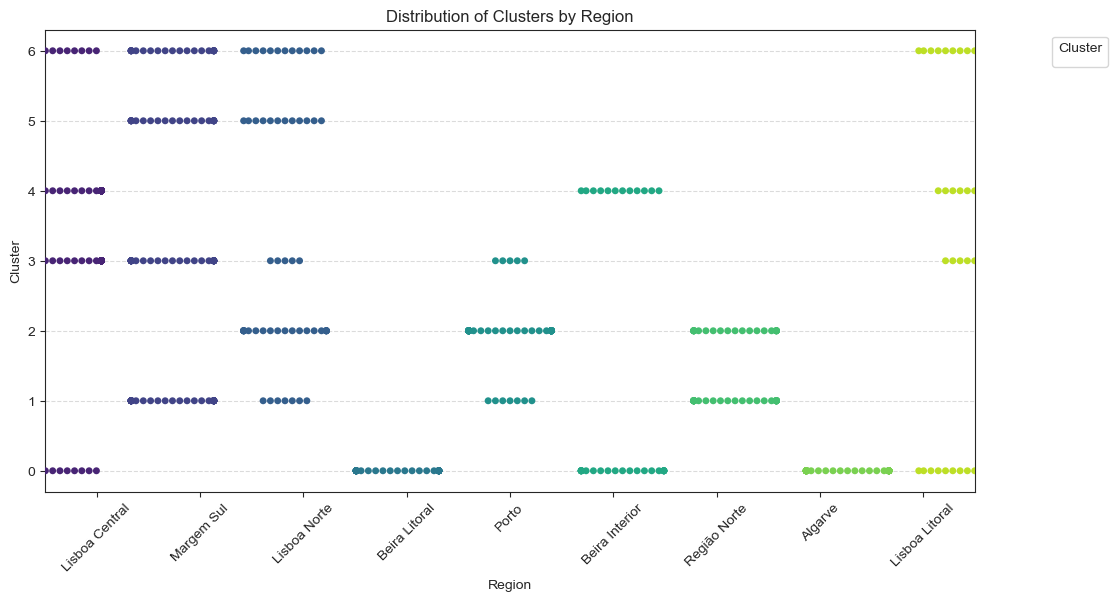

In [70]:
# Plot the distribution of clusters by region using swarmplot
plt.figure(figsize=(12, 6))
sns.swarmplot(data=monthly_data_by_store, x='REGIAO', y='hierarchical_cluster', palette='viridis', dodge=True)

# Add titles and labels
plt.title('Distribution of Clusters by Region')
plt.xlabel('Region')
plt.ylabel('Cluster')
plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.xticks(rotation=45)  # Rotate x-axis labels if region names are long
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Importancia das features

In [72]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Fit a RandomForest to determine feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(features_scaled, monthly_data_by_store['hierarchical_cluster'])

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': features.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)


              Feature  Importance
2      region_encoded    0.264144
3                 MES    0.220788
1       store_encoded    0.214431
4  PRODUTIVIDADE_HORA    0.177143
0         VENDA_TOTAL    0.123494


#### Estatisticas dos Clusters

In [73]:
# Calculate summary statistics for each cluster
cluster_summary = monthly_data_by_store.groupby('hierarchical_cluster').agg(
    total_sales_mean=('VENDA_TOTAL', 'mean'),
    total_sales_median=('VENDA_TOTAL', 'median'),
    total_sales_std=('VENDA_TOTAL', 'std'),
    average_productivity_mean=('PRODUTIVIDADE_HORA', 'mean'),
    average_productivity_median=('PRODUTIVIDADE_HORA', 'median'),
    average_productivity_std=('PRODUTIVIDADE_HORA', 'std'),
    region_encoded_mean=('region_encoded', 'mean'),
    region_encoded_median=('region_encoded', 'median'),
    region_encoded_std=('region_encoded', 'std'),
    month_mean=('MES', 'mean'),
    month_median=('MES', 'median'),
    month_std=('MES', 'std')
).reset_index()

print(cluster_summary)


   hierarchical_cluster  total_sales_mean  total_sales_median  \
0                     0      9.157595e+06        8.277652e+06   
1                     1      3.138687e+06        7.542912e+05   
2                     2      8.330198e+06        1.054821e+07   
3                     3      6.011232e+05        6.111929e+05   
4                     4      1.107470e+06        5.230348e+05   
5                     5      2.028572e+07        1.599158e+07   
6                     6      1.054519e+07        7.634840e+06   

   total_sales_std  average_productivity_mean  average_productivity_median  \
0     5.983859e+06                 235.615385                        233.0   
1     3.719379e+06                 202.156250                        220.0   
2     4.925274e+06                 190.444444                        200.0   
3     1.940380e+05                 149.668508                        146.0   
4     2.376904e+06                 139.581281                        145.0   
5     9.965

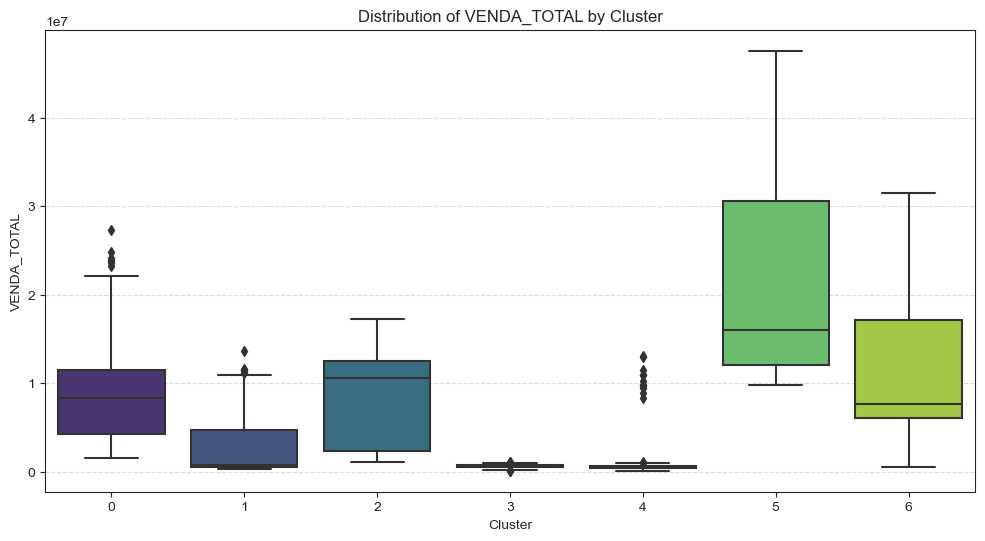

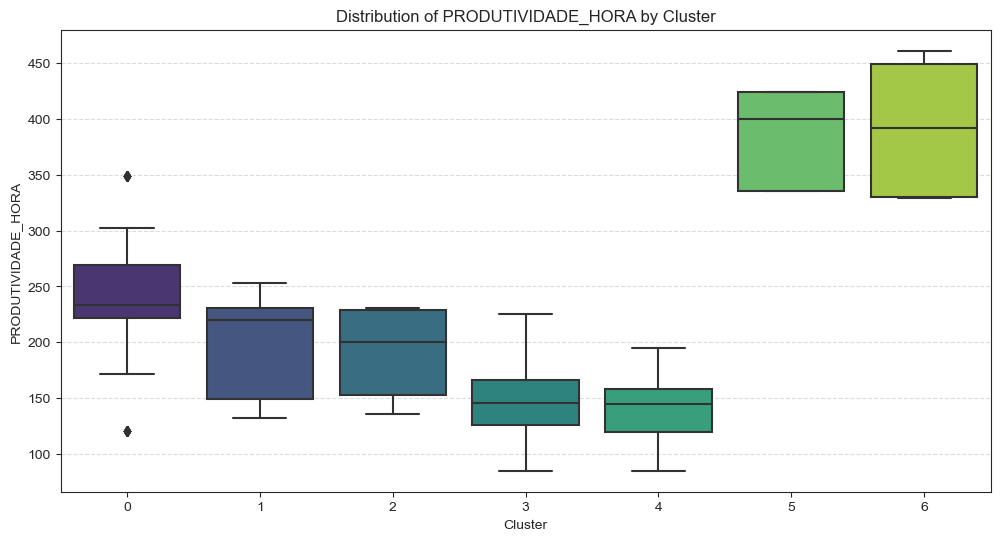

In [74]:
# Plot distributions of key features within each cluster
for feature in ['VENDA_TOTAL', 'PRODUTIVIDADE_HORA']:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='hierarchical_cluster', y=feature, data=monthly_data_by_store, palette='viridis')
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [78]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score for hierarchical clusters
sil_score_hierarchical = silhouette_score(features_scaled, monthly_data_by_store['hierarchical_cluster'])
print(f'Silhouette Score for Hierarchical Clustering: {sil_score_hierarchical}')


Silhouette Score for Hierarchical Clustering: 0.2880200818245732


Nota <br>
0.71 - 1.00: Strong clustering structure /
0.51 - 0.70: Reasonable structure /
0.26 - 0.50: Weak structure /
< 0.25: No substantial structure /

#### Experimentar mais um metodo - Gaussian Mixture Models

Silhouette Score for GMM: 0.5512606999396619


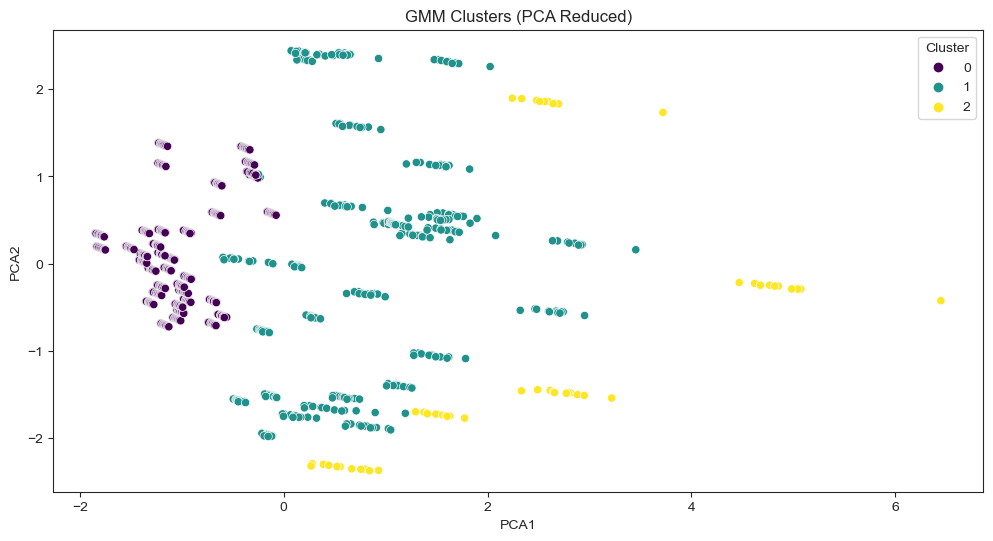

In [85]:
from sklearn.mixture import GaussianMixture

# Apply Gaussian Mixture Model
n_components = 3  # You can start with 5 and adjust based on the results
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm_clusters = gmm.fit_predict(features)

# Add the GMM cluster labels to the data
monthly_data_by_store['gmm_cluster'] = gmm_clusters

# Calculate silhouette score for GMM clusters
sil_score_gmm = silhouette_score(features, gmm_clusters)
print(f'Silhouette Score for GMM: {sil_score_gmm}')

# Visualize GMM clusters with PCA
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='gmm_cluster', data=monthly_data_by_store, palette='viridis')
plt.title('GMM Clusters (PCA Reduced)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()


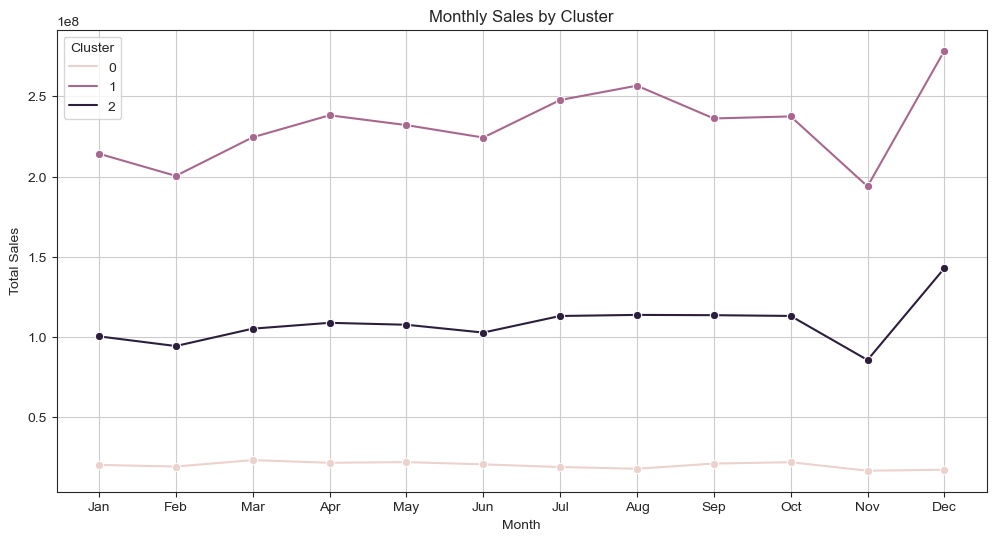

In [86]:
# Aggregate data by month and cluster to get total sales
clustered_monthly_sales = monthly_data_by_store.groupby(['MES', 'gmm_cluster']).agg(
    total_sales=('VENDA_TOTAL', 'sum')
).reset_index()

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=clustered_monthly_sales, x='MES', y='total_sales', hue='gmm_cluster', marker='o')

# Add titles and labels
plt.title('Monthly Sales by Cluster')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(title='Cluster')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()


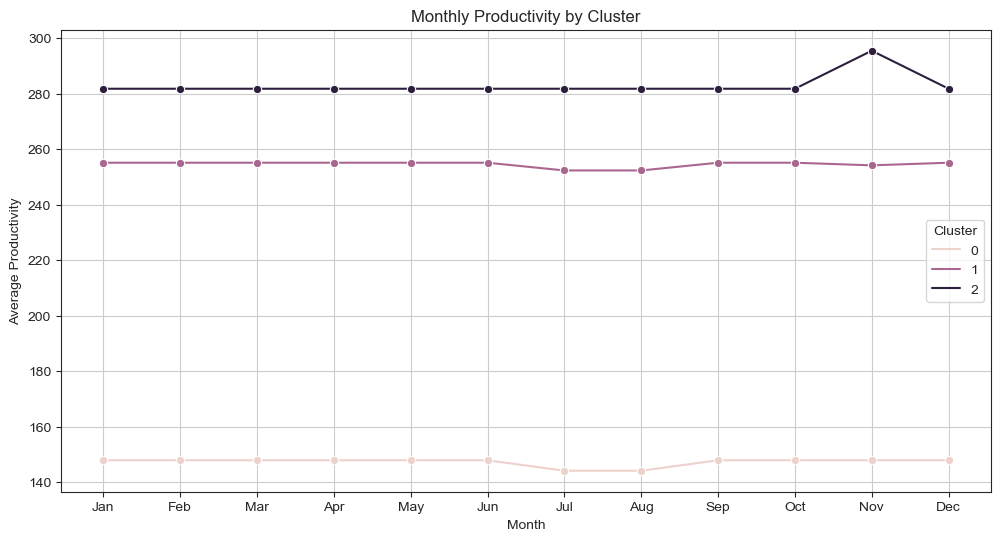

In [87]:
# Aggregate data by month and cluster to get average productivity
clustered_monthly_productivity = monthly_data_by_store.groupby(['MES', 'gmm_cluster']).agg(
    average_productivity=('PRODUTIVIDADE_HORA', 'mean')
).reset_index()

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=clustered_monthly_productivity, x='MES', y='average_productivity', hue='gmm_cluster', marker='o')

# Add titles and labels
plt.title('Monthly Productivity by Cluster')
plt.xlabel('Month')
plt.ylabel('Average Productivity')
plt.legend(title='Cluster')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


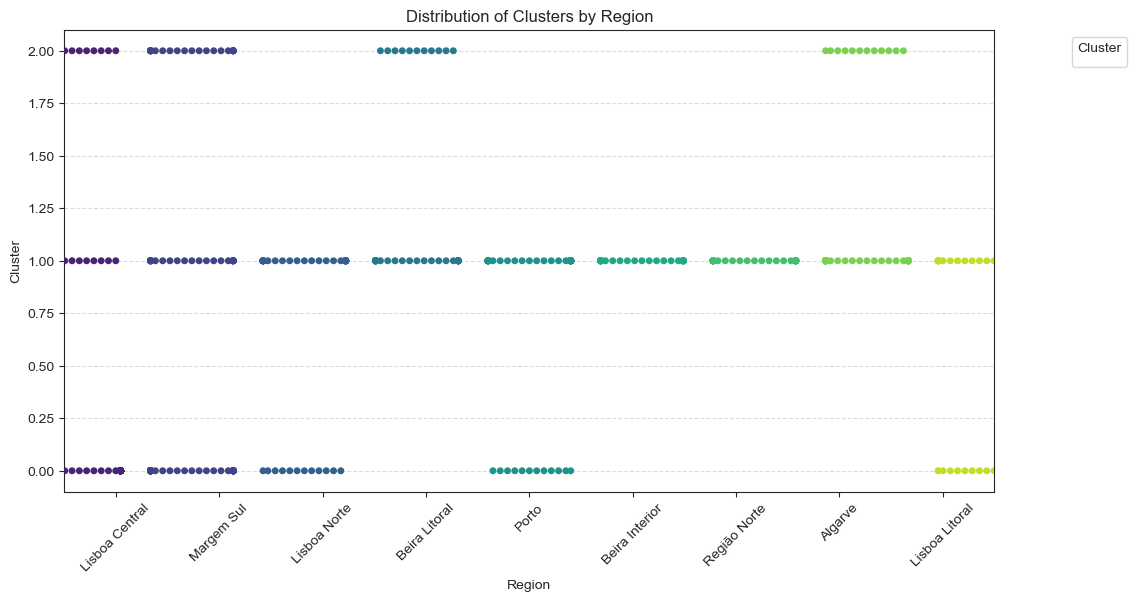

In [90]:
# Plot the distribution of clusters by region using swarmplot
plt.figure(figsize=(12, 6))
sns.swarmplot(data=monthly_data_by_store, x='REGIAO', y='gmm_cluster', palette='viridis', dodge=True)

# Add titles and labels
plt.title('Distribution of Clusters by Region')
plt.xlabel('Region')
plt.ylabel('Cluster')
plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.xticks(rotation=45)  # Rotate x-axis labels if region names are long
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [91]:
# Fit a RandomForest to determine feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(features_scaled, monthly_data_by_store['gmm_cluster'])

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': features.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)


              Feature  Importance
0         VENDA_TOTAL    0.476482
1       store_encoded    0.273265
4  PRODUTIVIDADE_HORA    0.201128
2      region_encoded    0.046018
3                 MES    0.003106


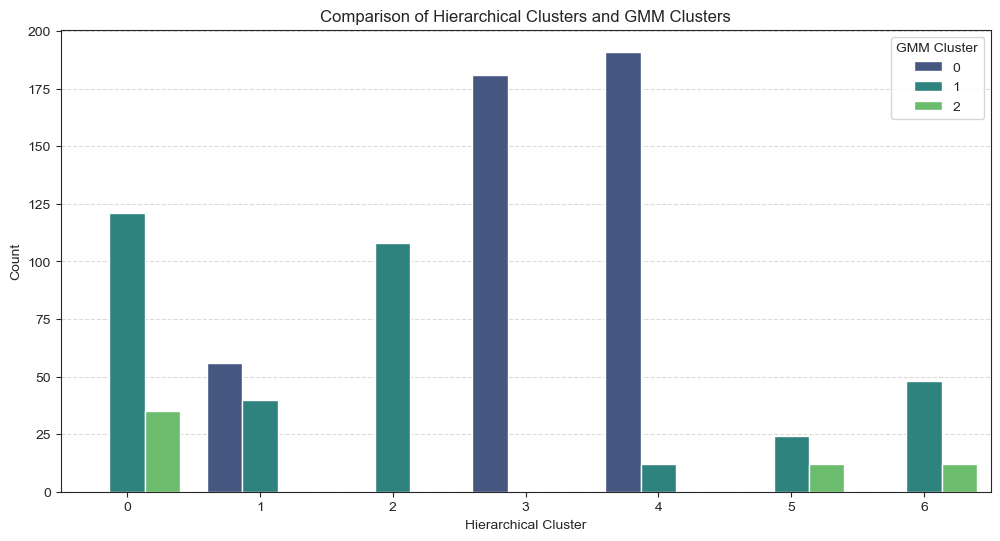

In [93]:
# Compare previous clusters with new clusters
comparison = monthly_data_by_store[['hierarchical_cluster', 'gmm_cluster']]

# Plot comparison
plt.figure(figsize=(12, 6))
sns.countplot(x='hierarchical_cluster', hue='gmm_cluster', data=comparison, palette='viridis')
plt.title('Comparison of Hierarchical Clusters and GMM Clusters')
plt.xlabel('Hierarchical Cluster')
plt.ylabel('Count')
plt.legend(title='GMM Cluster')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()
